In [67]:
import pandas as pd
from matplotlib import pyplot as plt
import math
import numpy as np
import random
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [68]:
data =pd.read_csv('train.csv').drop(['targetName'], axis=1)

In [69]:
sum_roads = data['class'].value_counts()

In [70]:
def find_last_coord_by_index(index_row):
    sum_null = data.iloc[index_row].isnull().sum()
    nun_colum = data.columns[len(data.columns)-1-sum_null]
    if nun_colum== 'class':
        index = 28
    else:
        index = int(nun_colum.split('_',1)[1])-1
    return ('posX_'+str(index),'posY_'+str(index))

def find_last_coord_by_row(row):
    sum_null = row.isnull().sum()
    nun_colum = data.columns[len(data.columns)-1-sum_null]
    if nun_colum== 'class':
        index = 28
    else:
        index = int(nun_colum.split('_',1)[1])-1
    return ('posX_'+str(index),'posY_'+str(index),'posZ_'+str(index))

In [71]:
def distinct(index_row):
    coord = find_last_coord_by_index(index_row)
    point = [data.loc[index_row,coord[0]],data.loc[index_row,coord[1]]]
    return math.dist([0,0],point)

In [72]:
def show_histograma(class_index):
    first_class= data[data['class']==class_index]
    first_class
    length = []
    for index, row in first_class.iterrows():
        length.append(distinct(index))
    plt.hist(length,bins=150)
    plt.title(f' class {class_index}')
    plt.show()

In [73]:
def show():
    for index in range(1,26):
        show_histograma(index)
# show()

In [74]:
def plot_road(row):
    pos_x, pos_z,index=[],[],0
    while  (index < 30) and not np.isnan(row[f'Time_{index}']):
        pos_x.append(row[f'posX_{index}'])
        pos_z.append(row[f'posZ_{index}'])
        index+=1
    return pos_x, pos_z

In [75]:
def plot_energy(row):
    energy,index=[],0
    while  (index < 30) and not np.isnan(row[f'Time_{index}']):
        energy.append(row[f'energy{index}'])
        index+=1
    return energy

In [76]:
def show_plot_road(data,class_type):
    colors_dict = {1:'b',2:'g',3:'r',4:'c' ,5:'m',6:'y',7:'deeppink',8:'peru',9:'cyan',10:'lawngreen',11:'salmon',12:'grey',13:'darkorchid',14:'violet',15:'pink',16:'r'}
    for index, row in data.iterrows():
        pos_x, pos_z = plot_road(row)
        plt.plot(pos_x, pos_z,color=colors_dict[int(row['class'])])
    plt.legend(class_type)
    plt.show()

In [77]:
def show_plot_energy(data,class_type):
    colors_dict = {1:'b',2:'g',3:'r',4:'c' ,5:'m',6:'y',7:'deeppink',8:'peru',9:'cyan',10:'lawngreen',11:'salmon',12:'grey',13:'darkorchid',14:'violet',15:'pink',16:'r'}
    x = [i for i in range(0,30)]
    for index, row in data.iterrows():
        energy = plot_energy(row)
        plt.plot(energy,color = colors_dict[int(row['class'])])
    plt.legend(class_type)
    plt.show()

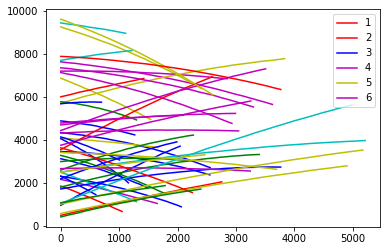

In [78]:
data_one_to_six = data[(1<=data['class']) & (data['class']<=6)].head(50)
show_plot_road(data_one_to_six,[1,2,3,4,5,6])

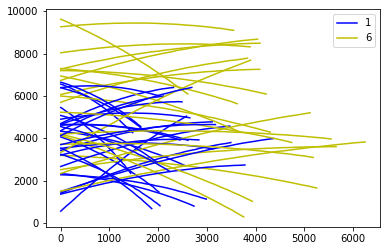

In [79]:
data_one_six = data[(1==data['class']) | (data['class']==6)]
data_15_lenght = data_one_six[~np.isnan(data_one_six['Time_29'])].head(50)
show_plot_road(data_15_lenght,[1,6])

# Machine Learning

### Help Functions

In [80]:
def kineticEnergy(V):
    KineticEnergy = 0.5 *  V * V
    return KineticEnergy

def potentialEnergy(H):
    PotentialEnergy = 10 * H
    return PotentialEnergy

In [81]:
def delete_nan(data):
    for index, row in data.iterrows():
        pos_x, pos_y, pos_z = find_last_coord_by_row(row)
        index_col=int(pos_x.split('_',1)[1])*7+7
        for cell_index in range(index_col, 210, 7):
            data.loc[index, cell_index:cell_index+7]=[0,row[pos_x], row[pos_y], row[pos_z], 0,0,0]
    return data

In [82]:
def energy_data(data):
    for index, row in data.iterrows():
        for col_index in range(30):
            x = row['velX_'+str(col_index)]
            y = row['velY_'+str(col_index)]
            z = row['velZ_'+str(col_index)]
            vel=math.sqrt(math.pow(x,2)+math.pow(y,2)+math.pow(z,2))
            data.loc[index,'energy'+str(col_index)] = [kineticEnergy(vel) + potentialEnergy(row['posZ_'+str(col_index)])]
    return data

In [83]:
def rocket_classification(rocket):
    if rocket['posZ_0'] > 7100 or rocket[find_last_coord_by_row(rocket)[0]]>4000:
        return 16
    return 1

In [84]:
def calculate_F1_score(testing, result,pair):
    # calculate F1-score
    t_n, f_p, f_n, t_p = confusion_matrix(testing, result, labels=pair).reshape(-1)
    precision = t_p/(t_p+f_p)
    recall = t_p/(t_p+f_n)
    
    f1_score = 2*(precision*recall)/(precision+recall)
    
    return f1_score

def testing_rockets(data,pair):
    
    result=[]
    for index, row in testing.iterrows():
        result.append(rocket_classification(row))
    return calculate_F1_score(class_testing, result,pair)

###### Use of classification types 

In [85]:
def test_by_logistic(x_train, y_train,):
    logisticRegr = LogisticRegression(random_state = 0, max_iter=150000000)
    logisticRegr.fit(x_train, y_train)
    predictions = logisticRegr.predict(x_test)
    return logisticRegr, predictions

In [86]:
def test_by_random_forest(x_train, y_train,x_test):
    rf = RandomForestRegressor(n_estimators = 1000, random_state = 0)
    rf.fit(x_train, y_train)
    predictions = rf.predict(x_train)
    return rf, predictions

### Data structure

In [87]:
pair=[5,6]
new_data = data[(data['class']==pair[0]) | (data['class']==pair[1])]

In [91]:
new_data_four_classes=data[(data['class']==1) | (data['class']==4) | (data['class']==7) | (data['class']==10)]
new_data_four_classes.drop('Unnamed: 0', axis=1, inplace=True)

In [92]:
machine_learning_data = new_data.copy()
machine_learning_data.drop('Unnamed: 0', axis=1, inplace=True)

In [93]:
training =new_data.sample(frac=0.8)
testing=new_data.drop(training.index)
class_testing = testing.loc[:,'class']
testing.drop('class', axis=1, inplace=True)

### Using Functions

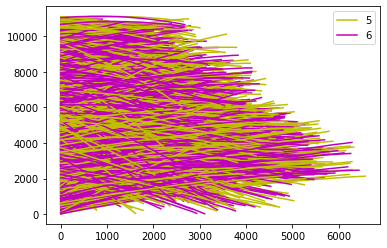

In [1627]:
show_plot_road(training, pair)

In [1628]:
machine_learning_data = delete_nan(machine_learning_data)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


In [1629]:
machine_learning_data = energy_data(machine_learning_data)

In [1630]:
# show_plot_energy(machine_learning_data, pair)

### Two classes

In [1631]:
class_data = machine_learning_data.loc[:,'class']
machine_learning_data.drop('class', axis=1, inplace=True)

In [1632]:
x_train, x_test, y_train, y_test = train_test_split(machine_learning_data, class_data, test_size=0.2, random_state=0)

In [1633]:
logisticRegr, predictions = test_by_logistic(x_train, y_train,x_test)
score = logisticRegr.score(x_test, y_test)
score

0.533003300330033

In [1588]:
rf, predictions = test_by_random_forest(x_train, y_train,x_test)
score = rf.score(x_test, y_test)
score

-0.012529128611959539

### Four classes

In [94]:
new_data_four_classes=delete_nan(new_data_four_classes)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1797: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)


In [95]:
new_data_four_classes = energy_data(new_data_four_classes)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)


In [96]:
classes=new_data_four_classes['class']
new_data_four_classes.drop('class', axis=1, inplace=True)

In [97]:
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(new_data_four_classes, classes, test_size=0.2, random_state=0)

In [98]:
rf, predictions = test_by_random_forest(x_train_rf,y_train_rf,x_test_rf)

In [99]:
score = rf.score(x_test_rf, y_test_rf)
score

0.9655513228393405

In [100]:
logisticRegr, predictions = test_by_logistic(x_train_rf,y_train_rf,x_test_rf)
score = logisticRegr.score(x_test_rf, y_test_rf)
score

TypeError: test_by_logistic() takes 2 positional arguments but 3 were given

In [ ]:
new_data_four_classes